<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Steps:" data-toc-modified-id="Steps:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Steps:</a></span><ul class="toc-item"><li><span><a href="#Implementing-the-transform-functions" data-toc-modified-id="Implementing-the-transform-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implementing the transform functions</a></span></li><li><span><a href="#Detect-edges" data-toc-modified-id="Detect-edges-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Detect edges</a></span></li><li><span><a href="#Finding-contours" data-toc-modified-id="Finding-contours-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Finding contours</a></span></li></ul></li></ul></div>

# Steps:
1. Implement image transformation functions
1. Detect edges
2. Use the edges in image to find the outline representing the piece of paper being scanned
1. Apply transform to obtain the top-down view of the document

## Implementing the transform functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The transformation function

In [2]:
def order_points(pts):
    # initialzie a list of coordinates in clockwise fashion,
    # starting from top-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect


def four_point_transform(image, pts):
    # obtain consistent ordering of points and unpack
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute width of new image
    # max distance between top and bottom widths
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # same for height
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # destination points to obtain a `bird's eye view`
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute transform matrix and apply to the image
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

Let's test this transformation function

In [3]:
# display images side-by-side
def display_sbs(imgLr, imgRr):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.rot90(imgLr,0))
    f.add_subplot(1,2, 2)
    plt.imshow(np.rot90(imgRr,0))
    plt.show(block=True)

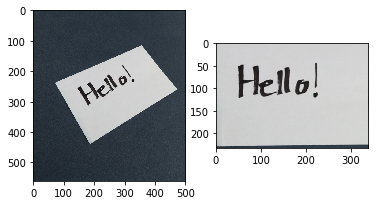

In [4]:
# the image input
image_hello1 = cv2.imread("images/transformation/example_01.png")
pts = np.array(
    [(73, 239), (356, 117), (475, 265), (187, 443)], dtype="float32")
warped_image_hello1 = four_point_transform(image_hello1, pts)

display_sbs(image_hello1, warped_image_hello1)

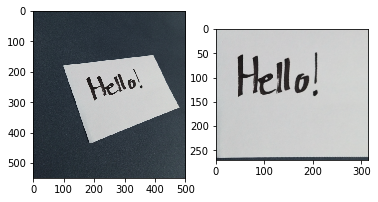

In [5]:
# try another image
image_hello2 = cv2.imread("images/transformation/example_02.png")
pts = np.array(
    [(101, 185), (393, 151), (479, 323), (187, 441)], dtype="float32")
warped_image_hello2 = four_point_transform(image_hello2, pts)

display_sbs(image_hello2, warped_image_hello2)

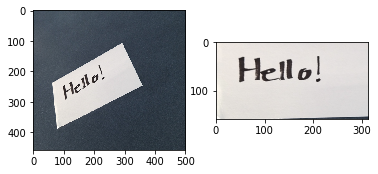

In [6]:
# another one!
image_hello3 = cv2.imread("images/transformation/example_03.png")
pts = np.array(
    [(63, 242), (291, 110), (361, 252), (78, 386)], dtype="float32")
warped_image_hello3 = four_point_transform(image_hello3, pts)

display_sbs(image_hello3, warped_image_hello3)

## Detect edges

In [7]:
# import some more libraries we need
from skimage.filters import threshold_local
import imutils

In [8]:
def detect_edges(image):
    # compute the ratio of old height
    # to the new height
    # clone and resize
    ratio = image.shape[0] / 500.0
    original = image.copy()
    image = imutils.resize(image, height = 500)
    
    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # apply gaussian blur
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # find edges in the image
    edged = cv2.Canny(gray, 75, 200)
    
    return edged

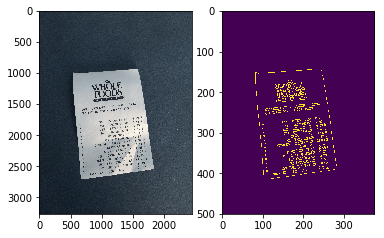

In [9]:
image_receipt = cv2.imread("images/receipt.jpg")
edged_receipt = detect_edges(image_receipt)
display_sbs(image_receipt, edged_receipt)

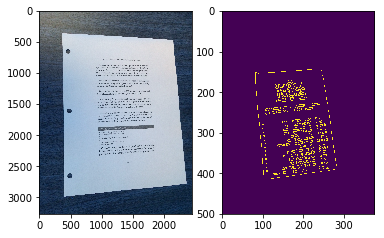

In [10]:
image_page = cv2.imread("images/page.jpg")
edged_page = detect_edges(image_receipt)
display_sbs(image_page, edged_page)

## Finding contours

In [11]:
def find_contours(edged):
    # takes edged image as input
    
    # find contours in edged image
    contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # if using CV2, use 0 else 1
    contours = contours[0] if imutils.is_cv2() else contours[1]
    # keep only the latest one
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    
    screen_contours = None
    
    for contour in contours:
        # approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approximate = cv2.approxPolyDP(contour, 0.002 * perimeter, True)
        
        # if the approximated contour has 4 points,
        # we have found our screen
        if len(approximate) == 4:
            screen_contours = approximate
            break
            
    return screen_contours

In [12]:
contours_receipt = find_contours(edged_receipt)
image_receipt_contours = image_receipt.copy()
cv2.drawContours(image_receipt_contours, [contours_receipt], -1, (0, 255, 0), 2)
plt.imshow(image_receipt_contours)

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/drawing.cpp:2613: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'
